# Importing libraries and data

In [7]:
import os
import glob

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [59]:
dataset_path = '/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2'

audio_path = os.path.join(dataset_path, 'respiratory_sound_database','Respiratory_Sound_Database', 'audio_and_txt_files')
audio_files = glob.glob(os.path.join(audio_path, '**/*.wav'), recursive=True)

# print(glob.glob(os.path.join(dataset_path, '*'), recursive=True))

print(f"Found {len(audio_files)} audio files.")

['/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/demographic_info.txt', '/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database', '/root/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/respiratory_sound_database']
Found 920 audio files.


# EDA

In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# Function to extract spectrogram from audio
def extract_spectrogram(audio_path, n_mels=128, fmax=8000, fixed_length=500):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        log_S = librosa.power_to_db(S, ref=np.max)
        padding = librosa.util.fix_length(log_S, size=fixed_length, axis=1)
        return padding
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Function to extract MFCCs from audio
def extract_mfcc(audio_path, n_mfcc=13, fixed_length=500):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        padding = librosa.util.fix_length(mfccs, size=fixed_length, axis=1)
        return padding
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Function to process all audio files in a given directory
def process_audio_files(dataset_path, extension='.wav', batch_size=10):
    audio_files = glob.glob(os.path.join(dataset_path, f'**/*{extension}'), recursive=True)
    spectrograms = []
    mfccs = []

    # Process audio files in batches
    for i, audio_path in enumerate(audio_files):
        spectrogram = extract_spectrogram(audio_path, fixed_length=batch_size)
        mfcc = extract_mfcc(audio_path, fixed_length=batch_size)

        if spectrogram is not None:
            spectrograms.append(spectrogram)
        if mfcc is not None:
            mfccs.append(mfcc)

        # Process in batches to reduce memory usage
        if len(spectrograms) >= batch_size:
            # print(f"Processed {i + 1}/{len(audio_files)} files")
            break


    # Check if any spectrograms were generated
    if not spectrograms:
        print("No spectrograms were generated.")

    return spectrograms, mfccs

In [37]:
# Get and print the list of files
spectrograms, mfccs = process_audio_files(dataset_path, batch_size=500)

/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Spectrograms shape: (500, 128, 500)


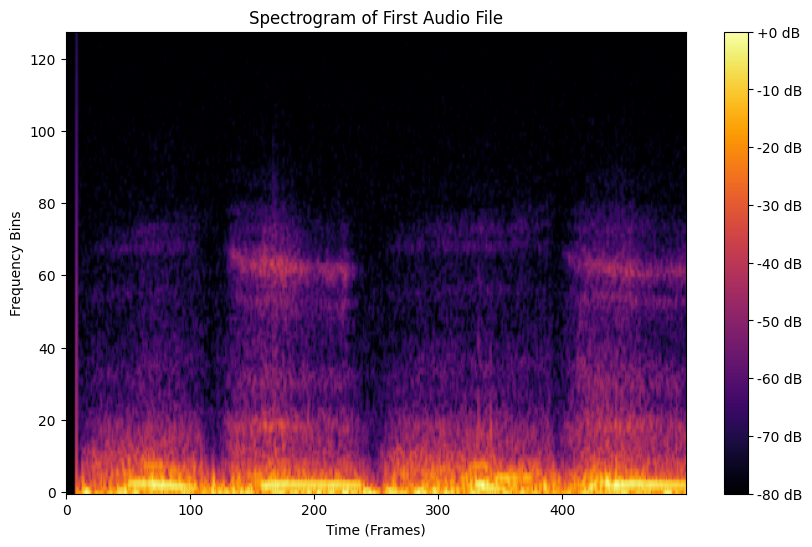

In [38]:
# Check if we have valid data for training
if spectrograms:
    print(f"Spectrograms shape: {np.array(spectrograms).shape}")

# Ensure there is data to proceed with
if spectrograms:
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrograms[0], aspect='auto', origin='lower', cmap='inferno')
    plt.title('Spectrogram of First Audio File')
    plt.xlabel('Time (Frames)')
    plt.ylabel('Frequency Bins')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

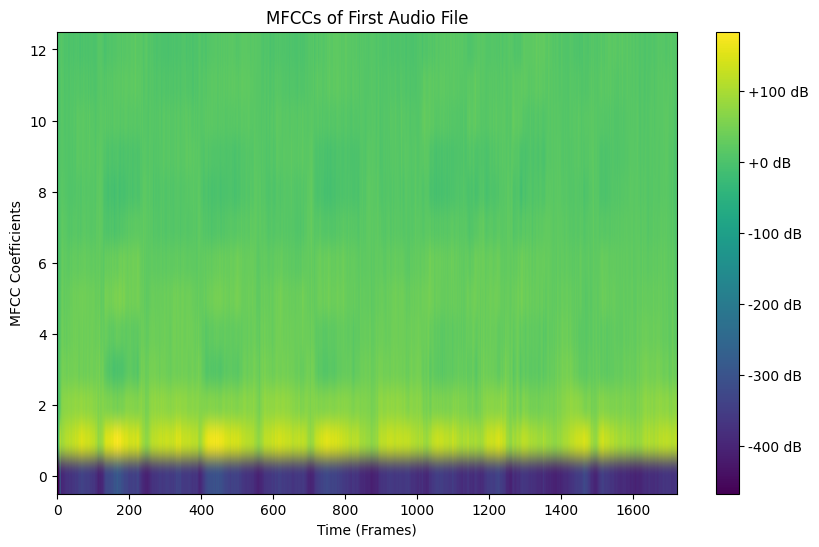

In [40]:
# Check MFCCs
# if mfccs:
#     print(f"MFCCs shape: {np.array(mfccs).shape}")

if mfccs:
    plt.figure(figsize=(10, 6))
    plt.imshow(mfccs[0], aspect='auto', origin='lower', cmap='viridis')
    plt.title('MFCCs of First Audio File')
    plt.xlabel('Time (Frames)')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Data Preparation

In [50]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [80]:
patient_diagnosis = os.path.join(dataset_path, 'demographic_info.txt')
col_names = ['patient_id', 'age', 'sex', 'adult_bmi', 'child_weight', 'child_height']
df_demo = pd.read_csv(patient_diagnosis, sep=" ", header=None, names=col_names)


# Load the disease diagnosis information
diagnosis_mapping = {}
diagnosis_file = os.path.join(dataset_path, 'demographic_info.txt')
with open(diagnosis_file, 'r') as f:
    for line in f:
        parts_diag = line.strip().split()  # Split on space or tab depending on your file format
        if len(parts_diag) >= 2:
            patient_id = parts_diag[0]
            diagnosis = parts_diag[1]
            diagnosis_mapping[patient_id] = diagnosis

print(diagnosis_mapping)

{'101': '3', '102': '0.75', '103': '70', '104': '70', '105': '7', '106': '73', '107': '75', '108': '3', '109': '84', '110': '75', '111': '63', '112': '60', '113': '58', '114': '77', '115': '0.58', '116': '56', '117': '68', '118': '81', '119': '2', '120': '78', '121': '13', '122': '66', '123': '5', '124': '65', '125': '14', '126': '1', '127': '2', '128': '65', '129': '6', '130': '85', '131': '3', '132': '71', '133': '68', '134': '61', '135': '70', '136': '5', '137': '4', '138': '56', '139': '61', '140': '79', '141': '66', '142': '78', '143': '0.25', '144': '3', '145': '69', '146': '67', '147': '77', '148': '4', '149': '0.67', '150': '0.67', '151': '75', '152': '16', '153': '3', '154': '65', '155': '69', '156': '80', '157': '62', '158': '63', '159': '0.83', '160': '74', '161': '2', '162': '67', '163': '62', '164': '1', '165': '2', '166': '71', '167': '1', '168': '19', '169': '50', '170': '79', '171': '9', '172': '73', '173': '3', '174': '68', '175': '63', '176': '65', '177': '56', '178':

In [79]:
patient_diagnosis = os.path.join(dataset_path, 'respiratory_sound_database','Respiratory_Sound_Database', 'patient_diagnosis.csv')
df_diag = pd.read_csv(patient_diagnosis, header=None, names=['patient_id', 'diagnosis'])

print(df_diag.shape)
df_diag.head()

(126, 2)


,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [51]:
def extract_features(file_path, sr=22050, n_mfcc=13):
    """
    Extract audio features including MFCCs, spectral centroid,
    zero crossing rate, spectral bandwidth, and chroma features.
    """
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

    if y.size == 0:
        print(f"File {file_path} is empty.")
        return None

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Spectral centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_centroid_mean = np.mean(spec_centroid)
    spec_centroid_std = np.std(spec_centroid)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    # Spectral bandwidth
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_bandwidth_mean = np.mean(spec_bandwidth)
    spec_bandwidth_std = np.std(spec_bandwidth)

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)

    # Combine features into a dictionary
    features = {}
    for i in range(n_mfcc):
        features[f'mfcc_{i+1}_mean'] = mfcc_mean[i]
        features[f'mfcc_{i+1}_std'] = mfcc_std[i]

    features['spec_centroid_mean'] = spec_centroid_mean
    features['spec_centroid_std'] = spec_centroid_std
    features['zcr_mean'] = zcr_mean
    features['zcr_std'] = zcr_std
    features['spec_bandwidth_mean'] = spec_bandwidth_mean
    features['spec_bandwidth_std'] = spec_bandwidth_std

    for i in range(chroma.shape[0]):
        features[f'chroma_{i+1}_mean'] = chroma_mean[i]
        features[f'chroma_{i+1}_std'] = chroma_std[i]

    return features

In [85]:
feature_list = []
labels = []

for file in audio_files:
    feats = extract_features(file)
    if feats is None:
        continue
    feature_list.append(feats)

    # Extract patient ID from the file name (first part)
    file_name = os.path.basename(file)
    parts = file_name.split('_')
    if len(parts) >= 1:
        patient_id = parts[0]

        # Get the disease diagnosis from df_diag using patient_id
        diagnosis_row = df_diag[df_diag['patient_id'] == int(patient_id)]

        # Check if the diagnosis exists for the patient
        if not diagnosis_row.empty:
            diagnosis = diagnosis_row['diagnosis'].values[0]
            # print(f"{patient_id} - {diagnosis}")

            # Map the diagnosis to a label
            if diagnosis == "Healthy":
                label = "healthy"
            elif diagnosis in ['COPD', 'LRTI', 'URTI']:
                label = "diseased"
            else:
                label = "unknown"
        else:
            label = "unknown"
            print(f"Warning: Missing diagnosis for patient {patient_id}. Label set to 'unknown'.")

        # print(f"Assigned label: {label}")
    else:
        label = "unknown"

    labels.append(label)

In [86]:
# Create DataFrame from features and labels
df_features = pd.DataFrame(feature_list)
df_features['label'] = labels

# Debug: Check label distribution before filtering
print("Label counts before filtering:")
print(df_features['label'].value_counts())

Label counts before filtering:
label
diseased    818
unknown      67
healthy      35
Name: count, dtype: int64


In [102]:
# Optionally, filter to only include the desired labels
df_features = df_features[df_features['label'].isin(['healthy', 'diseased'])]

print("Feature DataFrame shape:", df_features.shape)
print("-"*50)
print(df_features['label'].value_counts())
print("-"*50)
print(df_features.head())

Feature DataFrame shape: (853, 57)
--------------------------------------------------
label
diseased    818
healthy      35
Name: count, dtype: int64
--------------------------------------------------
   mfcc_1_mean  mfcc_1_std  mfcc_2_mean  mfcc_2_std  mfcc_3_mean  mfcc_3_std  \
0  -343.093536   29.952412   129.464554   23.538984    57.137108   13.150426   
1  -451.000732   49.517796   168.673981   38.312790    33.897675   16.030277   
2  -320.494202   25.450924   119.364792   15.085746    20.680239   17.162554   
3  -331.524872   33.619167   125.750999   32.117439    69.955528   11.766325   
4  -527.357483   22.656822    97.238029   10.683610    27.638781    4.460540   

   mfcc_4_mean  mfcc_4_std  mfcc_5_mean  mfcc_5_std  ...  chroma_8_std  \
0    36.122330   11.134090    42.005981    8.353015  ...      0.289734   
1   -18.121468   22.855856    10.084127   12.731071  ...      0.156312   
2    18.505249   12.401577    29.119179    7.046945  ...      0.196328   
3    30.763178   13.57

In [88]:
# Separate features and target labels
X = df_features.drop("label", axis=1)
y = df_features['label']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Model Building

## RandomForest Classification

In [89]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [90]:
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions and evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 97.08%


In [100]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred, target_names=le.classes_)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[164   0]
 [  5   2]]
Classification Report:
              precision    recall  f1-score   support

    diseased       0.97      1.00      0.98       164
     healthy       1.00      0.29      0.44         7

    accuracy                           0.97       171
   macro avg       0.99      0.64      0.71       171
weighted avg       0.97      0.97      0.96       171



### Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Set the style
sns.set_palette("husl")

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot
bars = ax.bar(range(len(importances)),
              importances[indices],
              color=sns.color_palette("Blues_r", len(importances)),
              align="center")

# Customize the plot
ax.set_title("Feature Importances", fontsize=14, pad=20)
ax.set_xlabel("Features", fontsize=12, labelpad=10)
ax.set_ylabel("Importance Score", fontsize=12, labelpad=10)

# Customize x-axis
ax.set_xticks(range(len(importances)))
ax.set_xticklabels(features[indices], rotation=45, ha='right')
ax.set_xlim([-0.5, len(importances)-0.5])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    # ax.text(bar.get_x() + bar.get_width()/2., height,
    #         f'{height:.3f}',
    #         ha='center', va='bottom')

# Add grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## SVM

In [91]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [92]:
# Create a pipeline that first scales the data then trains an SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
])

# Define a grid of hyperparameters to search over
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1],
}

In [93]:
# Set up grid search with 5-fold cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'svc__C': 10, 'svc__gamma': 0.01}
Best cross validation accuracy: 0.975053671103478


In [94]:
# Predict on the test set and evaluate accuracy
y_pred_svm = grid_search.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
svm = grid_search.best_estimator_

print(f"SVM Test Accuracy: {accuracy_svm*100:.2f}%")

SVM Test Accuracy: 95.91%


In [103]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred_svm, target_names=le.classes_)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[162   2]
 [  5   2]]
Classification Report:
              precision    recall  f1-score   support

    diseased       0.97      0.99      0.98       164
     healthy       0.50      0.29      0.36         7

    accuracy                           0.96       171
   macro avg       0.74      0.64      0.67       171
weighted avg       0.95      0.96      0.95       171



### Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the results from grid search
cv_results = grid_search.cv_results_
C_values = param_grid['svc__C']
gamma_values = param_grid['svc__gamma']

scores = cv_results['mean_test_score'].reshape(len(C_values), len(gamma_values))
fig, ax1 = plt.subplots(1, figsize=(15, 6))

sns.heatmap(scores,
            xticklabels=gamma_values,
            yticklabels=C_values,
            annot=True,
            fmt='.3f',
            cmap='viridis',
            ax=ax1)

ax1.set_title('Grid Search Scores (Cross-Validation Accuracy)')
ax1.set_xlabel('gamma')
ax1.set_ylabel('C')

In [ ]:
X, Y = np.meshgrid(np.log10(gamma_values), np.log10(C_values))
ax2 = plt.subplot(122, projection='3d')
surf = ax2.plot_surface(X, Y, scores,
                       cmap='viridis',
                       edgecolor='none')

ax2.set_title('3D Surface Plot of Grid Search Results')
ax2.set_xlabel('log10(gamma)')
ax2.set_ylabel('log10(C)')
ax2.set_zlabel('Accuracy')

fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

## Ensemble

In [95]:
from sklearn.ensemble import VotingClassifier

# Create an ensemble classifier with soft voting
ensemble_model = VotingClassifier(
    estimators=[('rf', clf), ('svm', svm)],
    voting='soft',
    weights=[3, 2]
)

# Train the ensemble model on the training data
ensemble_model.fit(X_train, y_train)

# Predict on the test set and evaluate accuracy
y_pred_ensemble = ensemble_model.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Test Accuracy: {accuracy_ensemble*100:.2f}%")

Ensemble Model Test Accuracy: 96.49%


# Try out

In [96]:
from sklearn.ensemble import VotingClassifier

def predict_lung_cancer_probability(wav_file, ensemble_model, feature_columns, label_encoder):
    # Extract features using the same function as for training
    feats = extract_features(wav_file)
    if feats is None:
        print(f"Error extracting features from {wav_file}.")
        return None

    input_data = pd.DataFrame([feats])
    input_data = input_data.reindex(columns=feature_columns, fill_value=0)

    # Predict probabilities using the ensemble model
    probas = ensemble_model.predict_proba(input_data)
    diseased_index = np.where(label_encoder.classes_ == 'diseased')[0][0]
    probability_diseased = probas[0, diseased_index]
    return probability_diseased

In [97]:
wav_tests = glob.glob('/content/test/*.wav')
feature_columns = df_features.drop("label", axis=1).columns

In [98]:
for test in wav_tests:
    probability = predict_lung_cancer_probability(test, ensemble_model, feature_columns, le)
    if probability is not None:
        print(f"Probability of lung cancer: {probability*100:.2f}%")

Probability of lung cancer: 90.50%
Probability of lung cancer: 91.70%
Probability of lung cancer: 91.70%


In [99]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap your ensemble classifier with calibration
calibrated_ensemble = CalibratedClassifierCV(ensemble_model, cv=5, method='isotonic')
calibrated_ensemble.fit(X_train, y_train)

# Now predict probabilities on new samples
for test in wav_tests:
    probability = predict_lung_cancer_probability(test, calibrated_ensemble, feature_columns, le)
    if probability is not None:
        print(f"Calibrated probability of lung cancer: {probability*100:.2f}%")

Calibrated probability of lung cancer: 97.50%
Calibrated probability of lung cancer: 97.50%
Calibrated probability of lung cancer: 97.50%
